## Anomaly Detection- windowed method 

In [56]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout

Importing the dataset

In [57]:
data = pd.read_csv("data/realKnownCause/realKnownCause/nyc_taxi.csv",
                   parse_dates=True, index_col="timestamp")
data

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


In [58]:
instances_of_anomaly= [
        [
            "2014-10-30 15:30:00.000000",
            "2014-11-03 22:30:00.000000"
        ],
        [
            "2014-11-25 12:00:00.000000",
            "2014-11-29 19:00:00.000000"
        ],
        [
            "2014-12-23 11:30:00.000000",
            "2014-12-27 18:30:00.000000"
        ],
        [
            "2014-12-29 21:30:00.000000",
            "2015-01-03 04:30:00.000000"
        ],
        [
            "2015-01-24 20:30:00.000000",
            "2015-01-29 03:30:00.000000"
        ]
    ]

In [59]:
data_with_anomaly = data.copy()
data_with_anomaly['anomaly'] = 0
for instance in instances_of_anomaly: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data_with_anomaly.loc[(data_with_anomaly.index >= start) & (data_with_anomaly.index <= end), 'anomaly'] = 1

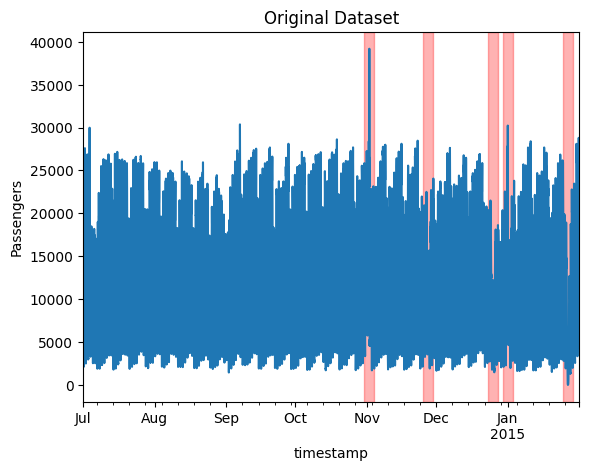

In [60]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
plt.ylabel("Passengers")
plt.title("Original Dataset")
plt.show()

Splitting training and testing

In [61]:
# Splitting to train and test
test_ratio =0.4
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]
data_with_anomaly= data_with_anomaly.iloc[int(len(data) * (1 - test_ratio)) :]

In [62]:
tr_data

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2014-11-06 21:30:00,26067
2014-11-06 22:00:00,25613
2014-11-06 22:30:00,23971


Normailzing the training set 

In [63]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = tr_data.mean()
training_std = tr_data.std()
train_scaled = (tr_data - training_mean) / training_std
print("Number of training samples:", len(train_scaled))

Number of training samples: 6192


Function to create the windowed data

In [64]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

Each sample is half an jour apart, so 336 samples accounts for a week

In [65]:
step_size = 336

train = create_sequences(train_scaled.values, step_size)
print("Training input shape: ", train.shape)

Training input shape:  (5857, 336, 1)


VAE model

In [66]:
from utils.sample import sample
from model.VAELossLayer import VAELossLayer

In [67]:
# Define VAE loss function
def vae_loss(x, x_decoded_mean, z_mean, z_log_var):
    # Reshape inputs to have the same shape
    x = tf.reshape(x, tf.shape(x_decoded_mean))
    
    # Compute reconstruction loss
    reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
    
    # Compute KL divergence
    kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    
    # Combine reconstruction loss and KL divergence
    total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    
    return total_loss

# Encoder
latent_dim = 8  # Dimensionality of the latent space
encoder_inputs = Input(shape=(train.shape[1], train.shape[2]))
x = layers.Conv1D(
    filters=32,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(encoder_inputs)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1D(
    filters=16,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
x = layers.Flatten()(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

# Use Lambda layer to sample from the latent distribution
z = layers.Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Instantiate encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(train.shape[1]*16, activation='relu')(latent_inputs)
x = layers.Reshape((int(train.shape[1]/4), 64))(x)  # Adjusted reshape operation
x = layers.Conv1DTranspose(
    filters=32,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1DTranspose(
    filters=16,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
decoder_outputs = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)


# Instantiate decoder model
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Instantiate VAE model
outputs = decoder(encoder(encoder_inputs)[2])



vae_loss_layer = VAELossLayer()([encoder_inputs, outputs, z_mean, z_log_var])

#vae = keras.Model(encoder_inputs, outputs, name="vae")
vae = keras.Model(encoder_inputs, [outputs, vae_loss_layer], name='vae')

vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [68]:
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 336, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 168, 32)   │        256 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 168, 32)   │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 84, 16)    │      3,600 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 8),       │     25,376 │ input_layer_4[0]… │
│ (Functional)        │ (None, 8), (None, │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1344)      │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 336, 1)    │     66,465 │ encoder[0][2]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │     10,760 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │     10,760 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_2    │ (None, 336, 1)    │          0 │ input_layer_4[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,841 (358.75 KB)

 Trainable params: 91,841 (358.75 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
history = vae.fit(
    train,
    train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

Epoch 1/50


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 36685.1875 - val_loss: 16755.8008
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 13298.3477 - val_loss: 8700.1426
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6553.5938 - val_loss: 5588.8896
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4611.0601 - val_loss: 4236.7959
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3579.4104 - val_loss: 3531.2065
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2921.7571 - val_loss: 3113.0171
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2502.6619 - val_loss: 2754.8196
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2223.9116 - val_loss: 2481.2231
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2018.2177 - val_loss: 2340.2615
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1868.9640 - val_loss: 2340.1218
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1786.7583 - val_loss: 2103.7937
Epoch

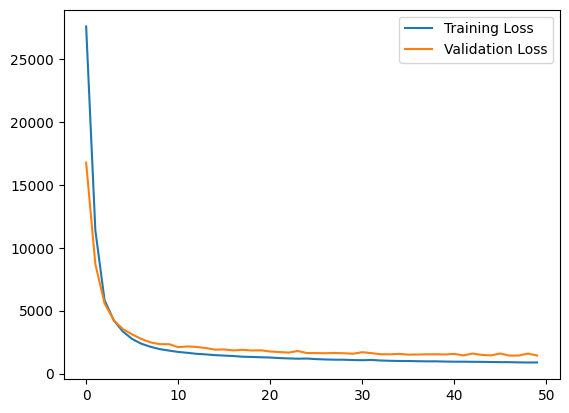

In [70]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(5857, 1)


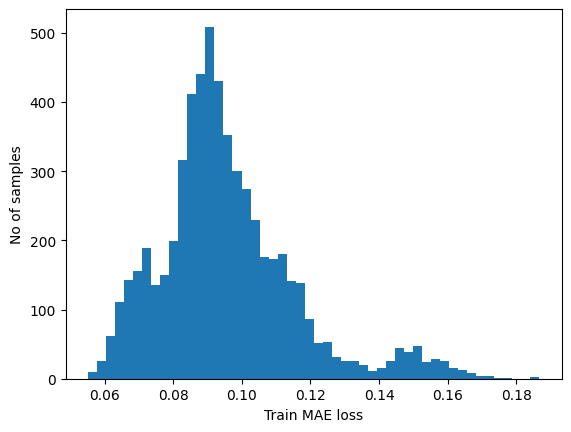

Reconstruction error threshold:  0.1866749108847076


In [71]:
# Get train MAE loss.
train_pred = vae.predict(train)[0]
train_mae_loss = np.mean(np.abs(train_pred - train), axis=1)
print(train_mae_loss.shape)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [72]:
print(train_pred.shape)

(5857, 336, 1)


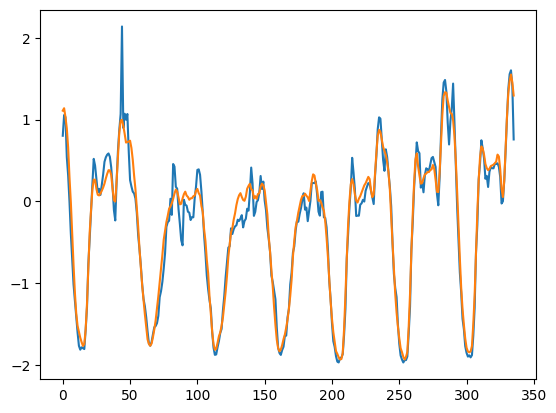

In [73]:
# Checking how the first sequence is learnt
plt.plot(train[90])
plt.plot(train_pred[90])
plt.show()

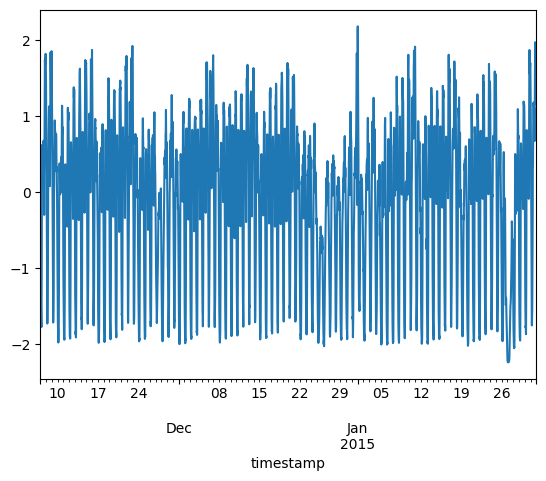

Test input shape:  (3793, 336, 1)
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(3793, 1)


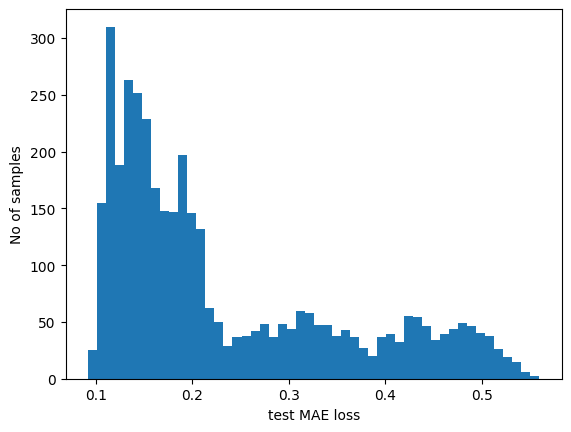

Number of anomaly samples:  1887
Indices of anomaly samples:  (array([ 644,  645,  646, ..., 3790, 3791, 3792], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64))


In [74]:

test_scaled = (tst_data - training_mean) / training_std
fig, ax = plt.subplots()
test_scaled.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test = create_sequences(test_scaled.values, step_size)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = vae.predict(test)[0]
test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
print(test_mae_loss.shape)
#test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [75]:
# anomalous_data_indices = []
# for ind in range(len(anomalies)):
#     if anomalies[ind]:
#         anomalous_data_indices.append(ind)

In [76]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
    if np.all(anomalies[data_idx - step_size + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [77]:
print("Indices of anomalies: ", anomalous_data_indices)

Indices of anomalies:  [979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2

In [78]:
df_subset = tst_data.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2014-11-27 09:30:00,9013
2014-11-27 10:00:00,9695
2014-11-27 10:30:00,11389
2014-11-27 11:00:00,12701
2014-11-27 11:30:00,13400
...,...
2015-01-04 22:00:00,11317
2015-01-04 22:30:00,10005
2015-01-04 23:00:00,8802


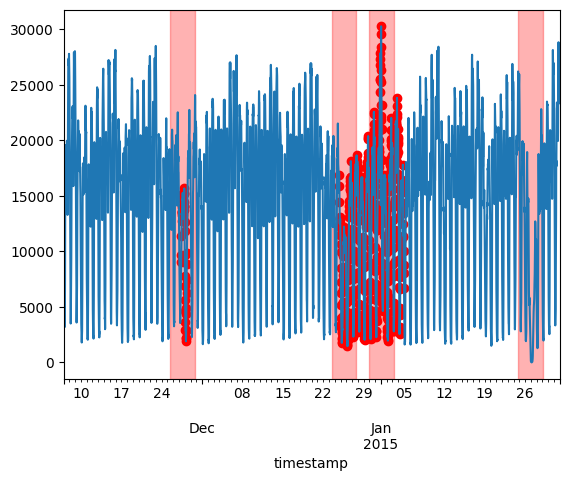

In [79]:
fig, ax = plt.subplots()
tst_data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
ax.scatter(df_subset.index, df_subset['value'], color="r")
plt.show()